In [1]:
import json
import numpy as np
import pandas as pd
from copy import copy

In [2]:
import terminal_optimization.visualisation        as visualisation
import terminal_optimization.forecast             as forecast
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.financial_analysis   as financial
import terminal_optimization.initial_terminal     as initial

# 1 Scenario Generator

In [3]:
def scenario_generator(start_year, simulation_window):
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Linear demand
    demand_maize  = 1000000        # demand at t=0
    growth_maize  = 100000       

    # Soybean - Exponential demand
    demand_soybean = 1000000
    rate_soybean   = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

    # Wheat - Probabilistic demand
    demand_wheat   = 1000000
    rate_wheat     = 1.05
    mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
    sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

    # Create forecast
    maize.linear_forecast(vessels, start_year, simulation_window, demand_maize, growth_maize)
    soybean.exponential_forecast(vessels, start_year, simulation_window, demand_soybean, rate_soybean)
    wheat.random_forecast(vessels, start_year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)
    commodities = [maize, soybean, wheat]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(maize, soybean, wheat, vessels)

    # Plot forecast
    visualisation.trend(maize, soybean, wheat, 10, 5)
    
    return vessels, commodities

# 2 Simulator

In [4]:
def simulate(vessels, commodities, terminal, start_year, simulation_window):
    
    for i in range (start_year, start_year + simulation_window):
        year = i 
        timestep = year - start_year

        ######################
        # Investment Decisions
        ######################           
        
        # Berths
        allowable_berth_occupancy = 0.15
        terminal.berths, terminal.cranes = invest.berth_invest_decision(terminal.berths, terminal.cranes, allowable_berth_occupancy, vessels, year, timestep, operational_hours)
        
        # Quay
        quays = invest.quay_invest_decision(quays, berths, quay_object, year, timestep)

        # Cranes 
        cranes = invest.crane_invest_decision(cranes, berths, cranes_object, year, timestep)

        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        storage = invest.storage_invest_decision(storage, storage_object, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        stations = invest.station_invest_decision(stations, station_object, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        q_conveyors = invest.quay_conveyor_invest_decision(q_conveyors, cranes, quay_conveyor_object, year, timestep, operational_hours)
        h_conveyors = invest.hinterland_conveyor_invest_decision(h_conveyors, stations, hinterland_conveyor_object, year, timestep, operational_hours)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        throughputs = financial.throughput_calc(throughputs, commodities, berths, cranes, year, timestep, operational_hours)

        # Revenues
        revenues = financial.revenue_calc(revenues, commodities, throughputs, year, timestep)

        # Capex
        capex = financial.capex_calc(capex, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Labour costs
        labour = financial.labour_calc(labour, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep, operational_hours)

        # Maintenance costs
        maintenance = financial.maintenance_calc(maintenance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Energy costs
        energy = financial.energy_calc(energy, berths, cranes, storage, stations, q_conveyors, h_conveyors, year, operational_hours, timestep)

        # Insurance costs
        insurance = financial.insurance_calc(insurance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Lease costs 
        lease = financial.lease_calc(lease, year,timestep)

        # Demurrage costs
        demurrage = financial.demurrage_calc(demurrage, year, berths, vessels, timestep)

        # Residual value calculations 
        residuals = financial.residual_calc(residuals, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Profits
        profits = financial.profit_calc(profits, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, simulation_window, timestep, year, start_year)
        
        # Opex
        opex = financial.opex_calc(opex, labour, maintenance, energy, insurance, lease, demurrage, year, timestep)
        
        # WACC depreciated profits
        #profits_WACC = financial.WACC_calc(profits, simulation_window)
            
    return quays, berths, cranes, storage, stations, q_conveyors, h_conveyors, throughputs, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, profits, opex

# Simulation Run

AttributeError: 'berth_class' object has no attribute 'pending_occupancy'

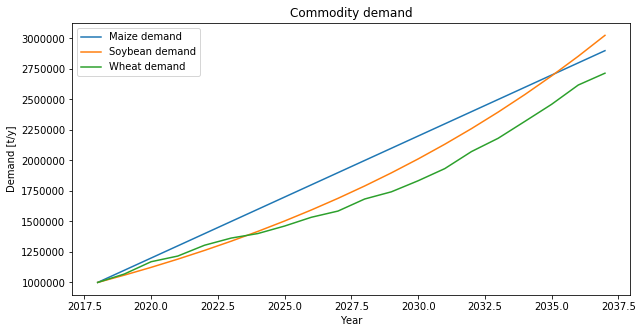

In [5]:
# Simulation parameters
start_year        = 2018   # start year of simulation
simulation_window = 20     # forecast 20 years ahead
operational_hours = 4680   # operational hours per year

# Run scenario generator
vessels, commodities = scenario_generator(start_year, simulation_window)

# Import existing terminal infrastructure 
terminal = initial.terminal()
quays, berths, cranes, storage, stations, q_conveyors, h_conveyors, throughputs, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, profits, opex = simulate(vessels, commodities, terminal, start_year, simulation_window)

# 4 Preliminary Plots
### Profit/loss

In [ ]:
# Plotting annualised profits
visualisation.profit_loss(profits, 10, 5)

### Annual cashflows

In [ ]:
# Plotting yearly cashflows
visualisation.all_cashflows(revenues, capex, labour, maintenance, energy, insurance, demurrage, residuals, 10, 5)

### Demand vs. Capacity

In [ ]:
# Plotting capacity vs. demand 
visualisation.throughput(commodities, throughputs, 10, 5)

# 5 NPV

In [ ]:
#NPV = financial.NPV_calc(profits_WACC)
#NPV